In [98]:
from jupyterthemes import jtplot

import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
import networkx as nx

from run_classroom_seating import get_model_state
from classroom_seating import ClassroomModel, ClassroomDesign

jtplot.style(figsize=(10, 5))

In [11]:
"""
Set the parameters
"""
seed = 0
num_of_samples = 20

# The classroom layout
blocks = [10, 15, 10]
num_rows = 20
width = sum(blocks) + len(blocks) - 1
entrances = [(width-1, 0)]
pos_utilities = np.zeros((width, num_rows))
classroom = ClassroomDesign(blocks, num_rows, pos_utilities, entrances)

# The social network of Students
cliques = 60
clique_size = 6
max_num_agents = cliques * clique_size
prob_linked_cliques = 0.3
social_network = nx.to_numpy_matrix(nx.relaxed_caveman_graph(cliques, clique_size, prob_linked_cliques, seed))

# The coefficients for the utility function [position, friendship, sociability, accessibility]
coefs_position_accessibility = [1, 0, 0, 0.1]
coefs_sociability = [1, 0, 1, 0.1]
coefs_friendship = [1, 1, 1, 0.1]

model_pos_access = ClassroomModel(max_num_agents, classroom, coefs_position_accessibility)
model_sociability = ClassroomModel(max_num_agents, classroom, coefs_sociability)
model_friendship = ClassroomModel(max_num_agents, classroom, coefs_friendship, social_network=social_network)

In [12]:
"""
Run model and save locally
"""
def run_model(model, path):
    for i in range(num_iterations):
        model.step()

    model_state = get_model_state(model)

    with open(path, "wb") as f:
        pkl.dump(model_state, f)

### Generate Data

In [149]:
"""
Generate a bunch of test samples

WARNING SLOW

Model Names:
 - model_pa: Position + Accesibility
 - model_s: Position + Accesibility + Sociability
 - model_f: Position + Accesibility + Spciability + Friendships
 
"""
# num_of_samples = 20
# print('Model PA')
# for i in range(num_of_samples):
#     print(i, end=', ')
#     model = ClassroomModel(max_num_agents, classroom, coefs_position_accessibility, seed=i+1)
#     run_model(model, "./test_models/model_pa%s.pkl"%i)

# print('\nModel PAS')
# for i in range(num_of_samples):
#     print(i, end=', ')
#     model = ClassroomModel(max_num_agents, classroom, coefs_sociability, seed=i+1)
#     run_model(model, "./test_models/model_s%s.pkl"%i)
    
# print('\nModel PASF')
# for i in range(10):
#     print(i, end=', ')
#     model = ClassroomModel(max_num_agents, classroom, coefs_friendship, social_network=social_network, seed=i+1)
#     run_model(model, "./test_models/model_f%s.pkl"%i)


'\nGenerate a bunch of test samples\n\nWARNING SLOW\n\nModel Names:\n - model_pa: Position + Accesibility\n - model_s: Position + Accesibility + Sociability\n - model_f: Position + Accesibility + Spciability + Friendships\n \n'

### Utilities

In [140]:
"""
Reduces model to a 1 if seat full, otherwise 0, and strips aisles
"""
def reduce_model_state(model_state):
    # assumes model uses blocks as set above
    # width = sum(blocks)
    # height = num_rows - 1   # remove the horizontal aisle

    result = np.copy(model_state)
    aisles = np.cumsum(blocks)[:-1]

    for a in aisles:
        result = np.delete(result, a, 1)
    result = np.delete(result, 0, 0)

    for seat in np.nditer(result, op_flags=['readwrite']):
        seat[...] = 1 if seat > 0 else 0

    return result


"""
Calculate the MSE between a model and a model profile. Both must have same dimension.

Args:
    model_counts: Counts of each state in comparision method (ie cluster sizes or convolutions)
    profile: The count profile to compare model to
"""
def calculate_mse(model_counts, profile):
    return ((profile - model_counts)**2).mean()


"""
Returns count of each length of cluster

Args:
    model_state: Model state WITHOUT aisles (ie reduced)
"""
def count_clusters(model_state):
    count = np.zeros(max(blocks)+1)

    limits = [0] + list(np.cumsum(blocks))

    for row in model_state:
        b = []
        for i in range(len(limits)-1):
            b.append(row[limits[i]:limits[i+1]])

        for block in b:
            c = 0
            for seat in block:
                if seat == 1:
                    c += 1
                else:
                    count[c] += 1
                    c = 0
            count[c] += 1

    return np.delete(count, 0, 0)


"""
Returns a count of each value in the convolution (0 to 255)

Advantages:
    - Captures a sense of spacial distribution
    - Can work on any shaped lecture theater

Args:
    model_state: Model state WITHOUT aisles (ie reduced)
"""
def count_convolution_values(model_state):
    i_diff = [-1, -1, -1, 0, 1, 1, 1, 0]
    j_diff = [-1, 0, 1, 1, 1, 0, -1, -1]
    
    count = np.zeros(256)
    
    for i in np.arange(1, model_state.shape[0] - 1):
        for j in np.arange(1, model_state.shape[1] - 1):
            total = 0
            for k in range(8):
                total += model_state[i + i_diff[k], j + j_diff[k]] * 2**k
            count[int(total)] += 1
    
    return count


"""
Loads the model state from path. Option to load as reduced model

Args:
    path: Path to model
    reduced: Reduce the model to just seating positions, no aisles (default False)
"""
def load_model_state(path, reduced=False):
    with open(path, "rb") as f:
        model_state = pkl.load(f)[0]
    if reduced:
        return reduce_model_state(model_state)
    else:
        return model_state

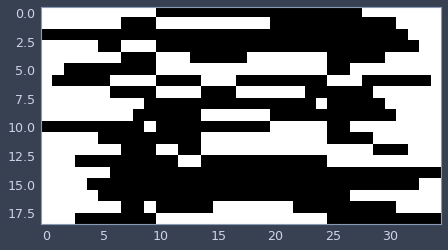

In [151]:
# Test a model can be loaded

model = load_model_state("./test_models/model_f0.pkl", True)
plt.imshow(model, cmap="Greys")
plt.grid(False)
plt.show()

### Using Cluster MSE

In [152]:
"""
Build cluster profiles of model types
"""

pa_cluster_profile = np.zeros(max(blocks))
for i in range(num_of_samples):
    model_state = load_model_state("./test_models/model_pa%s.pkl"%i, True)
    pa_cluster_profile += count_clusters(model_state)
pa_cluster_profile /= num_of_samples

s_cluster_profile = np.zeros(max(blocks))
for i in range(num_of_samples):
    model_state = load_model_state("./test_models/model_s%s.pkl"%i, True)   
    s_cluster_profile += count_clusters(model_state)
s_cluster_profile /= num_of_samples

f_cluster_profile = np.zeros(max(blocks))
for i in range(num_of_samples):
    model_state = load_model_state("./test_models/model_f%s.pkl"%i, True)
    f_cluster_profile += count_clusters(model_state)
f_cluster_profile /= num_of_samples

cluster_profiles = [pa_cluster_profile, s_cluster_profile, f_cluster_profile]
cluster_profile_names = ["PA", "PAS", "PASF"]

Mean Square Errors between model and profiles:
Model PA: 	 58.32
Model PAS: 	 9.47
Model PASF: 	 134.16


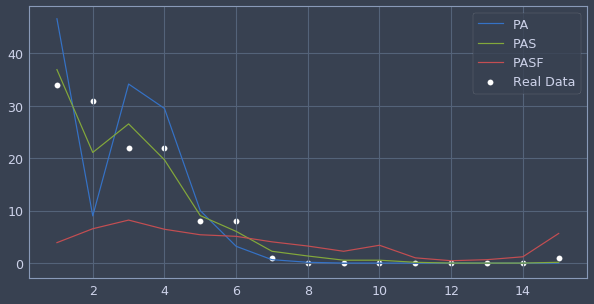

In [153]:
plt.figure(figsize=[10, 5])

real_model_state = load_model_state("./test_models/model_s1.pkl", True)
real_profile = count_clusters(real_model_state)
print("Mean Square Errors between model and profiles:")
for i, p in enumerate(cluster_profiles):
    mse = calculate_mse(real_profile, p)
    print("Model %s: \t %.2f"%(cluster_profile_names[i], mse))
    plt.plot(np.arange(1, 16), p, label=cluster_profile_names[i])

plt.scatter(np.arange(1, 16), real_profile, label="Real Data", c='w')
plt.legend()
plt.show()

In [156]:
classification = np.zeros(len(cluster_profiles))

for i in range(num_of_samples):
    model_state = load_model_state("./test_models/model_s%s.pkl"%i, True)
    profile = count_clusters(model_state)
    best = 0
    lowest = 100000
    for j in range(len(classification)):
        mse = calculate_mse(profile, cluster_profiles[j])
        if mse < lowest:
            best = j
            lowest = mse
    
    classification[best] += 1
    
print(classification)

[  3.  17.   0.]


### Using Convolution MSE

In [157]:
"""
Generate a profile for each model type

pa
f
s
"""

pa_conv_profile = np.zeros(256)
for i in range(num_of_samples):
    model_state = load_model_state("./test_models/model_pa%s.pkl"%i, True)
    pa_conv_profile += count_convolution_values(model_state)
pa_conv_profile /= num_of_samples

s_conv_profile = np.zeros(256)
for i in range(num_of_samples):
    model_state = load_model_state("./test_models/model_s%s.pkl"%i, True)   
    s_conv_profile += count_convolution_values(model_state)
s_conv_profile /= num_of_samples

f_conv_profile = np.zeros(256)
for i in range(num_of_samples):
    model_state = load_model_state("./test_models/model_f%s.pkl"%i, True)
    f_conv_profile += count_convolution_values(model_state)
f_conv_profile /= num_of_samples

conv_profiles = [pa_conv_profile, s_conv_profile, f_conv_profile]
conv_profile_names = ["PA", "PAS", "PASF"]

Mean Square Errors between model and profiles:
Model PA: 	 9.28
Model PAS: 	 1.55
Model PASF: 	 21.28


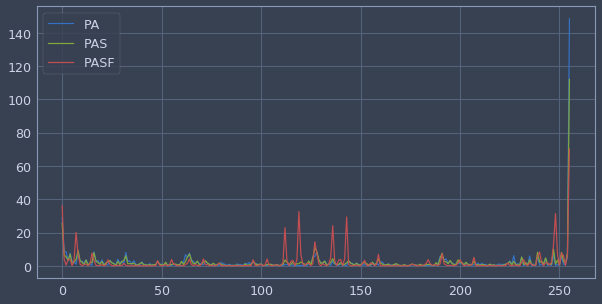

In [158]:
real_profile = count_convolution_values(load_model_state("./test_models/model_s8.pkl", True))

plt.figure(figsize=[10, 5])
print("Mean Square Errors between model and profiles:")
for i, p in enumerate(conv_profiles):
    mse = calculate_mse(real_profile, p)
    print("Model %s: \t %.2f"%(conv_profile_names[i], mse))
    plt.plot(p, label=conv_profile_names[i])

plt.legend()
plt.show()

In [162]:
# test robustness of convolution method

classification = np.zeros(len(conv_profiles))

for i in range(num_of_samples):
    profile = count_convolution_values(load_model_state("./test_models/model_s%s.pkl"%i, True))
    
    best = 0
    lowest = 100000
    for j in range(len(classification)):
        mse = calculate_mse(profile, conv_profiles[j])
        if mse < lowest:
            best = j
            lowest = mse
    
    classification[best] += 1
    
print(classification)

[  2.  18.   0.]


### Using GLCM Texture Analysis

In [18]:
from skimage.feature import greycomatrix, greycoprops
# from skimage import data

In [22]:
patch_real = reduce_model_state(np.array(real_model_state, dtype=np.uint8))

bsf_patches = []
for i in range(10):
    with open("./test_models/model_bsf%s.pkl"%i, "rb") as f:
        model_state = pkl.load(f).T
    
    
    bsf_patches.append(reduce_model_state(np.array(model_state, dtype=np.uint8)))
    
bs_patches = []
for i in range(10):
    with open("./test_models/model_bs%s.pkl"%i, "rb") as f:
        model_state = pkl.load(f).T
        
    bs_patches.append(reduce_model_state(np.array(model_state, dtype=np.uint8)))

b_patches = []
for i in range(10):
    with open("./test_models/model_b%s.pkl"%i, "rb") as f:
        model_state = pkl.load(f).T
        
    b_patches.append(reduce_model_state(np.array(model_state, dtype=np.uint8)))

In [48]:
glcm_real = greycomatrix(b_patches[2], [0, 1, 2, 3], [0, np.pi/2, np.pi], 2, symmetric=True, normed=False)
print(greycoprops(glcm_real, 'energy'))

[[ 1330.  1330.  1330.]
 [ 1292.  1260.  1292.]
 [ 1254.  1190.  1254.]
 [ 1216.  1120.  1216.]]
